이미지에서 사진 학습된 딥러닝 모델 사용하여 특징 벡터 추출 -> 클러스터링

## 특징 벡터 추출

In [5]:
from torchvision import models, transforms
from PIL import Image
import torch
import numpy as np
import os

In [6]:
# 사전 학습된 모델 로드
model = models.resnet50(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# 이미지 전처리
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# 특징 벡터 추출 함수
def extract_features(image_path):
    try:
        image = Image.open(image_path).convert("RGB") # 이미지 열기
        input_tensor = preprocess(image).unsqueeze(0) # 배치 차원 추가
        with torch.no_grad():
            features = model(input_tensor) # 특징 추출
        return features.squeeze().numpy() # 1D 벡터 반환
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [9]:
image_folder = r"E:\AI_HUB\data\Validation\raw_data\VS_photo"

In [10]:
# 사진 ID 및 특징 벡터 저장
photo_ids = []
features = []

In [11]:
# 파일별 처리
external_drive_path = r"E:\AI_HUB\data\Validation\features"

# 저장 경로 생성
if not os.path.exists(external_drive_path):
    os.makedirs(external_drive_path)  # 경로 생성

# 이미지 처리 및 특징 벡터 추출
for filename in os.listdir(image_folder):
    try:
        file_path = os.path.join(image_folder, filename)  # 파일 경로 생성
        feature_vector = extract_features(file_path)  # 특징 벡터 추출
        if feature_vector is not None:  # 성공적으로 처리된 경우만 저장
            photo_ids.append(filename)  # 사진 ID 저장
            features.append(feature_vector)  # 특징 벡터 저장
    except Exception as e:
        print(f"Error processing {filename}: {e}")

# 저장 경로 설정
features_path = os.path.join(external_drive_path, "features.npy")
photo_ids_path = os.path.join(external_drive_path, "photo_ids.npy")

# 데이터 저장
np.save(features_path, features)  # 특징 벡터 저장
np.save(photo_ids_path, photo_ids)  # 사진 ID 저장

print(f"Features saved to: {features_path}")
print(f"Photo IDs saved to: {photo_ids_path}")

C:\Users\user\anaconda3\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Features saved to: E:\AI_HUB\data\Validation\features\features.npy
Photo IDs saved to: E:\AI_HUB\data\Validation\features\photo_ids.npy


In [15]:
# 저장된 파일 경로
features_path = r"E:\AI_HUB\data\Validation\features\features.npy"
photo_ids_path = r"E:\AI_HUB\data\Validation\features\photo_ids.npy"

# 파일 로드
features = np.load(features_path)
photo_ids = np.load(photo_ids_path)

# 데이터 출력
print("Shape of features:", features.shape)  # 배열의 크기 출력
print("First 5 entries of features:", features[:5])  # 첫 5개 특징 벡터 출력
print("First 5 photo IDs:", photo_ids[:5])  # 첫 5개 사진 ID 출력

Shape of features: (1839, 1000)
First 5 entries of features: [[ 1.8425189   1.1464311  -1.646923   ...  3.2854257   7.8569975
  -0.605785  ]
 [-0.15482284 -1.5995772   1.0220279  ... -2.7714899   0.11804457
   2.2224002 ]
 [-4.332637   -1.6512784  -1.7111615  ... -3.193697    1.5569072
   1.555699  ]
 [-0.74991804  1.3840241   0.9988704  ... -1.2919858  -0.9668802
  -0.8893636 ]
 [-2.1255393  -0.04338136 -1.348523   ... -3.3169835   0.06077627
   2.3951862 ]]
First 5 photo IDs: ['e00106401002p0004.jpg' 'e00271201099p0004.jpg' 'e00301501004p0004.jpg'
 'e00123601099p0008.jpg' 'e00123601003p0009.jpg']


## 클러스터링 K-Means: 사진을 k개의 그룹으로 나눔

In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# 데이터 로드
features = np.load(r"E:\AI_HUB\data\Validation\features\features.npy")
photo_ids = np.load(r"E:\AI_HUB\data\Validation\features\photo_ids.npy")

# 빈 배열 확인
if features.size == 0 or photo_ids.size == 0:
    raise ValueError("Features or photo IDs array is empty. Please check the input files.")

# 데이터 정규화
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# K-Means clustering
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(features_normalized)

# 클러스터 중심 출력
for i in range(n_clusters):
    centroid = np.round(kmeans.cluster_centers_[i], 2)
    print(f"Cluster {i} centroid: {centroid}")

# 샘플 이미지 시각화 및 자동 라벨 생성
for cluster in range(n_clusters):
    cluster_indices = [i for i, label in enumerate(labels) if label == cluster]
    if not cluster_indices:
        print(f"Cluster {cluster} is empty.")
        continue
    representative_idx = cluster_indices[0]
    print(f"Cluster {cluster} representative image: {photo_ids[representative_idx]}")

Cluster 0 centroid: [ 0.93 -0.12 -0.65 -0.05 -0.28 -0.05 -0.07  0.3   0.45  1.24  0.02 -0.36
 -0.25 -0.24 -0.09  0.51  0.1  -0.38  0.48 -0.41  0.39  0.61  0.31  0.71
 -0.01  0.44  0.66  0.36  0.32  0.42  0.63 -0.24  0.46  0.23  0.33  0.96
  0.6   0.32 -0.16 -0.23 -0.37 -0.05 -0.02 -0.16  0.21  0.4  -0.63  0.48
  0.37  0.3   0.43  0.58  0.53  0.43  0.28  0.02 -0.18  0.26  0.36  0.62
 -0.22 -0.2   0.3   0.48  0.08  0.12  0.46  0.46  0.44 -0.1   0.26 -0.33
 -0.38 -0.14 -0.26 -0.42 -0.19  0.03  0.15 -0.1   0.66  0.87  0.5   0.74
  0.31  0.51  0.91 -0.56 -0.52  0.41 -0.12  0.29 -0.02  0.23 -0.29  0.09
  0.    0.27  0.44  0.75  0.52  0.93  0.44  0.57  1.07 -0.51  0.73  0.16
  0.43  0.49 -0.07  0.06  0.1   0.45  0.15  0.29  0.23 -0.07  0.15  0.23
  0.45 -0.   -0.06 -0.01  0.3   0.35 -0.1   0.83  0.66  0.48  0.61  0.49
  0.42  0.38  0.7   0.92  0.38  0.76  0.78  0.32  0.35  0.37  0.63  0.54
  0.03  0.54  0.58 -0.05  0.02  0.37 -0.16  0.25  0.52 -0.05 -0.22 -0.35
  0.45  0.04 -0.12  0.52  0.53 

Cluster 0 representative image path: E:\AI_HUB\data\Validation\raw_data\VS_photo\e00246101002p0010.jpg


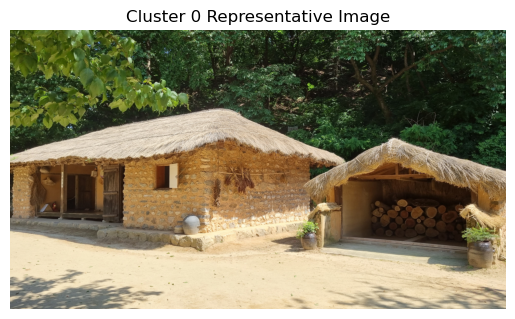

Cluster 1 representative image path: E:\AI_HUB\data\Validation\raw_data\VS_photo\e00123601004p0006.jpg


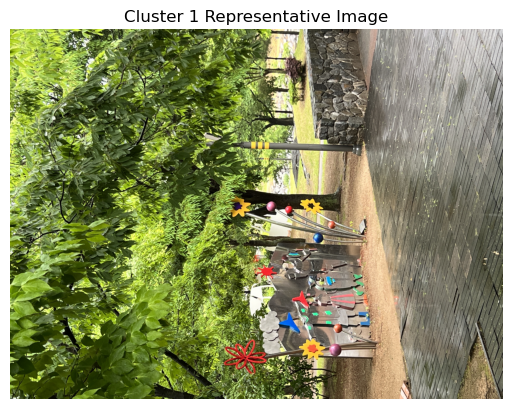

Cluster 2 representative image path: E:\AI_HUB\data\Validation\raw_data\VS_photo\e00123601004p0007.jpg


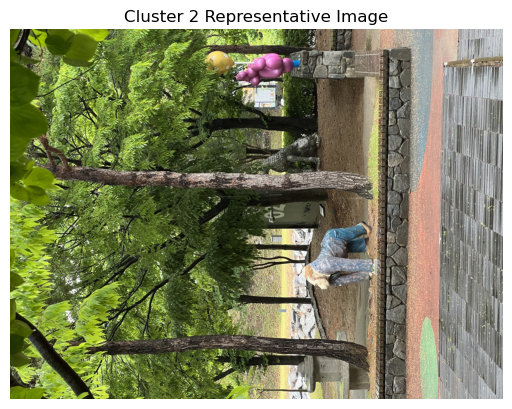

Cluster 3 representative image path: E:\AI_HUB\data\Validation\raw_data\VS_photo\e00149201009p0002.jpg


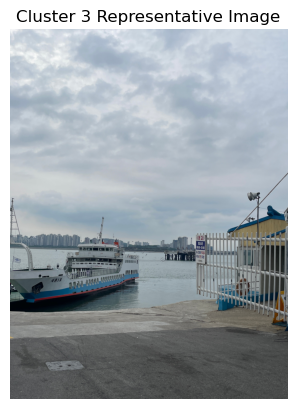

Cluster 4 representative image path: E:\AI_HUB\data\Validation\raw_data\VS_photo\e00227301003p0003.jpg


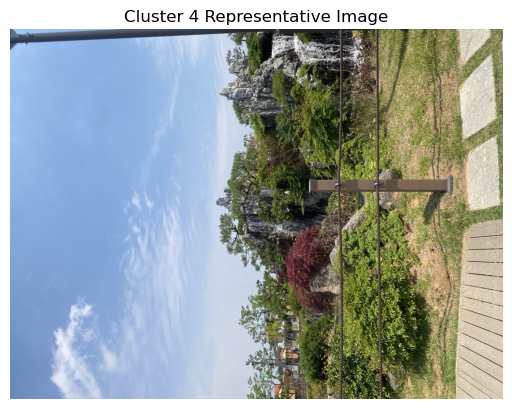

Cluster 5 representative image path: E:\AI_HUB\data\Validation\raw_data\VS_photo\e00106401002p0004.jpg


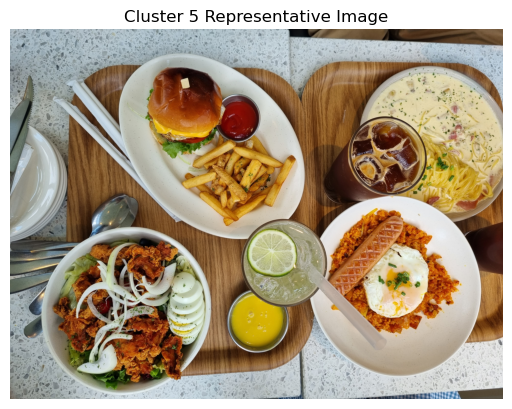

Cluster 6 representative image path: E:\AI_HUB\data\Validation\raw_data\VS_photo\e00123601099p0008.jpg


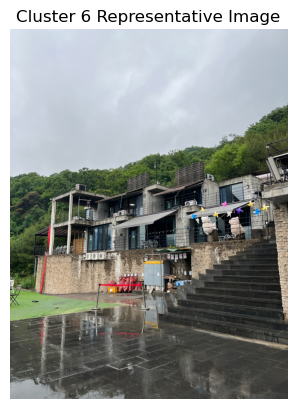

In [18]:
from PIL import Image
import os
import matplotlib.pyplot as plt

# 이미지 폴더 경로
image_folder = r"E:\AI_HUB\data\Validation\raw_data\VS_photo"

# 대표 이미지 출력
for cluster in range(n_clusters):
    cluster_indices = [i for i, label in enumerate(labels) if label == cluster]
    if not cluster_indices:
        print(f"Cluster {cluster} is empty.")
        continue
    representative_idx = cluster_indices[0]
    representative_image_path = os.path.join(image_folder, photo_ids[representative_idx])
    
    # 이미지 열기 및 표시
    print(f"Cluster {cluster} representative image path: {representative_image_path}")
    try:
        image = Image.open(representative_image_path)
        plt.figure()
        plt.title(f"Cluster {cluster} Representative Image")
        plt.imshow(image)
        plt.axis("off")
        plt.show()
    except Exception as e:
        print(f"Error opening image {representative_image_path}: {e}")


In [19]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [20]:
# K-means 클러스터링 및 t-SNE 차원 축소
def kmeans_and_tsne(data, n_clusters=6, random_state=42):
    # 1. K-means 클러스터링
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(data)
    
    # 클러스터 결과를 데이터프레임에 추가
    data_with_clusters = pd.DataFrame(data)
    data_with_clusters['Cluster'] = clusters

    # 2. t-SNE 차원 축소
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=30, learning_rate=200, n_iter=1000)
    tsne_results = tsne.fit_transform(data)

    # t-SNE 결과를 데이터프레임에 추가
    data_with_clusters['t-SNE 1'] = tsne_results[:, 0]
    data_with_clusters['t-SNE 2'] = tsne_results[:, 1]
    
    return data_with_clusters

# 데이터 예제 (여기서 data는 n_samples x n_features 형태의 numpy 배열 또는 DataFrame)
# data = np.random.rand(100, 5)  # 샘플 데이터

# K-means와 t-SNE 수행
n_clusters = 4  # 클러스터 개수
data_with_clusters = kmeans_and_tsne(data, n_clusters=n_clusters)

# 3. 결과 시각화
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    subset = data_with_clusters[data_with_clusters['Cluster'] == cluster]
    plt.scatter(subset['t-SNE 1'], subset['t-SNE 2'], label=f'Cluster {cluster}')
plt.title("t-SNE Visualization of K-means Clustering")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.show()

NameError: name 'data' is not defined